In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [21]:
df1 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2007-2009.csv')
df2 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2010-2012.csv')
df3 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2013-2015.csv')
df4 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2016-2018.csv')
df5 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2019-2021.csv')
df6 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2022-2024.csv')

In [22]:
penerimaan_pajak = df1[df1.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df1 = pd.DataFrame({
    'Tahun': ['2007', '2008', '2009'],
    'Penerimaan Pajak': penerimaan_pajak.values.flatten()
})
cleaned_df1.head()

penerimaan_pajak2 = df2[df2.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df2 = pd.DataFrame({
    'Tahun': ['2010', '2011', '2012'],
    'Penerimaan Pajak': penerimaan_pajak2.values.flatten()
})

penerimaan_pajak3 = df3[df3.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df3 = pd.DataFrame({
    'Tahun': ['2013', '2014', '2015'],
    'Penerimaan Pajak': penerimaan_pajak3.values.flatten()
})

penerimaan_pajak4 = df4[df4.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df4 = pd.DataFrame({
    'Tahun': ['2016', '2017', '2018'],
    'Penerimaan Pajak': penerimaan_pajak4.values.flatten()
})

penerimaan_pajak5 = df5[df5.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df5 = pd.DataFrame({
    'Tahun': ['2019', '2020', '2021'],
    'Penerimaan Pajak': penerimaan_pajak5.values.flatten()
})

penerimaan_pajak6 = df6[df6.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df6 = pd.DataFrame({
    'Tahun': ['2022', '2023', '2024'],
    'Penerimaan Pajak': penerimaan_pajak6.values.flatten()
})

In [23]:
df = pd.concat([cleaned_df1, cleaned_df2, cleaned_df3, cleaned_df4, cleaned_df5, cleaned_df6], axis=0).reset_index(drop=True)
print(df)

   Tahun Penerimaan Pajak
0   2007           490988
1   2008         658701.0
2   2009         619922.0
3   2010           723307
4   2011         873874.0
5   2012         980518.1
6   2013        1077306.7
7   2014        1146865.8
8   2015       1240418.86
9   2016        1284970.1
10  2017        1343529.8
11  2018        1518789.8
12  2019        1546141.9
13  2020       1285136.32
14  2021        1547841.1
15  2022        2034552.5
16  2023        2118348.0
17  2024        2309859.8


In [24]:
df_prophet = df[['Tahun', 'Penerimaan Pajak']].rename(columns={'Tahun': 'ds', 'Penerimaan Pajak': 'y'})
print(df_prophet)

      ds           y
0   2007      490988
1   2008    658701.0
2   2009    619922.0
3   2010      723307
4   2011    873874.0
5   2012    980518.1
6   2013   1077306.7
7   2014   1146865.8
8   2015  1240418.86
9   2016   1284970.1
10  2017   1343529.8
11  2018   1518789.8
12  2019   1546141.9
13  2020  1285136.32
14  2021   1547841.1
15  2022   2034552.5
16  2023   2118348.0
17  2024   2309859.8


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load and concatenate data
dfs = []
for i in range(1, 7):
    df = pd.read_csv(f'./data/Realisasi Pendapatan Negara, {2007 + (i-1)*3}-{2009 + (i-1)*3}.csv')
    penerimaan_pajak = df[df.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
    cleaned_df = pd.DataFrame({
        'Tahun': [str(year) for year in range(2007 + (i-1)*3, 2010 + (i-1)*3)],
        'Penerimaan Pajak': penerimaan_pajak.values.flatten()
    })
    dfs.append(cleaned_df)

data = pd.concat(dfs).reset_index(drop=True)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data['Penerimaan Pajak'] = scaler.fit_transform(data['Penerimaan Pajak'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
dataset = data['Penerimaan Pajak'].values
dataset = dataset.reshape(-1, 1)
train_size = int(len(dataset) * 0.67)
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0, trainX.shape[1], 1]))
testX = np.reshape(testX, (testX.shape[0, testX.shape[1], 1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

In [ ]:
# # Initialize the Prophet model
# model_prophet = Prophet()

# # Fit the model
# model_prophet.fit(df_prophet)

# # Make future dataframe for predictions
# future = model_prophet.make_future_dataframe(periods=10, freq='YE')  # Use 'A' for annual frequency
# forecast = model_prophet.predict(future)

# # Ensure 'Penerimaan Pajak' is numeric
# df['Penerimaan Pajak'] = pd.to_numeric(df['Penerimaan Pajak'], errors='coerce')

# # Calculate residuals
# df['yhat'] = forecast['yhat'][:len(df)]
# df['residuals'] = df['Penerimaan Pajak'] - df['yhat']

# # Preprocess the residuals
# scaler = MinMaxScaler()
# scaled_residuals = scaler.fit_transform(df[['residuals']])

# model_tf.add(Dense(25))
# model_tf.add(Dense(1))

# # Compile the model
# model_tf.compile(optimizer='adam', loss='mean_squared_error')

# # Reshape the data for LSTM
# X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
# y_train = train[:, 0]  # Assuming the target variable is the first column

# # Train the TensorFlow model for multiple epochs
# model_tf.fit(X_train, y_train, batch_size=1, epochs=50)  # Increase the number of epochs

# # Make predictions with the TensorFlow model
# X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
# y_pred_tf = model_tf.predict(X_test)

# # Use the predictions from the TensorFlow model as input features for the Gaussian Process model
# X_gp_train = np.arange(len(y_pred_tf)).reshape(-1, 1)
# y_gp_train = y_pred_tf.flatten()# Initialize the Prophet model
# model_prophet = Prophet()

# # Fit the model
# model_prophet.fit(df_prophet)

# # Make future dataframe for predictions
# future = model_prophet.make_future_dataframe(periods=10, freq='YE')  # Use 'A' for annual frequency
# forecast = model_prophet.predict(future)

# # Ensure 'Penerimaan Pajak' is numeric
# df['Penerimaan Pajak'] = pd.to_numeric(df['Penerimaan Pajak'], errors='coerce')

# # Calculate residuals
# df['yhat'] = forecast['yhat'][:len(df)]
# df['residuals'] = df['Penerimaan Pajak'] - df['yhat']

# # Preprocess the residuals
# scaler = MinMaxScaler()
# scaled_residuals = scaler.fit_transform(df[['residuals']])

# model_tf.add(Dense(25))
# model_tf.add(Dense(1))

# # Compile the model
# model_tf.compile(optimizer='adam', loss='mean_squared_error')

# # Reshape the data for LSTM
# X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
# y_train = train[:, 0]  # Assuming the target variable is the first column

# # Train the TensorFlow model for multiple epochs
# model_tf.fit(X_train, y_train, batch_size=1, epochs=50)  # Increase the number of epochs

# # Make predictions with the TensorFlow model
# X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
# y_pred_tf = model_tf.predict(X_test)

# # Use the predictions from the TensorFlow model as input features for the Gaussian Process model
# X_gp_train = np.arange(len(y_pred_tf)).reshape(-1, 1)
# y_gp_train = y_pred_tf.flatten()

# # Define the kernel for the Gaussian Process
# kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# # Create Gaussian Process model
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# # Fit the Gaussian Process model
# gp.fit(X_gp_train, y_gp_train)

# # Make predictions with the Gaussian Process model
# X_gp_test = np.arange(len(y_pred_tf), len(y_pred_tf) + len(test)).reshape(-1, 1)
# y_pred_gp, sigma = gp.predict(X_gp_test, return_std=True)

# # Inverse transform the predictions
# y_pred_gp = scaler.inverse_transform(y_pred_gp.reshape(-1, 1))

# # Combine Prophet predictions with Gaussian Process predictions
# df['yhat_combined'] = df['yhat']
# df.loc[train_size:, 'yhat_combined'] += y_pred_gp.flatten()

# # Evaluate the combined model
# y_test = df['Penerimaan Pajak'][train_size:].values
# y_pred_combined = df['yhat_combined'][train_size:].values
# mse = mean_squared_error(y_test, y_pred_combined)
# mae = mean_absolute_error(y_test, y_pred_combined)
# print(f'MSE: {mse}, MAE: {mae}')
# train, test = scaled_residuals[:train_size], scaled_residuals[train_size:]

# # Define the TensorFlow model
# model_tf = Sequential()
# model_tf.add(LSTM(50, return_sequences=True, input_shape=(train.shape[1], 1)))
# model_tf.add(LSTM(50, return_sequences=False))
# model_tf.add(Dense(25))
# model_tf.add(Dense(1))

# # Compile the model
# model_tf.compile(optimizer='adam', loss='mean_squared_error')

# # Reshape the data for LSTM
# X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
# y_train = train[:, 0]  # Assuming the target variable is the first column

# # Train the TensorFlow model for multiple epochs
# model_tf.fit(X_train, y_train, batch_size=1, epochs=50)  # Increase the number of epochs

# # Make predictions with the TensorFlow model
# X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
# y_pred_tf = model_tf.predict(X_test)

# # Use the predictions from the TensorFlow model as input features for the Gaussian Process model
# X_gp_train = np.arange(len(y_pred_tf)).reshape(-1, 1)
# y_gp_train = y_pred_tf.flatten()

# # Define the kernel for the Gaussian Process
# kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# # Create Gaussian Process model
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# # Fit the Gaussian Process model
# gp.fit(X_gp_train, y_gp_train)

# # Make predictions with the Gaussian Process model
# X_gp_test = np.arange(len(y_pred_tf), len(y_pred_tf) + len(test)).reshape(-1, 1)
# y_pred_gp, sigma = gp.predict(X_gp_test, return_std=True)

# # Inverse transform the predictions
# y_pred_gp = scaler.inverse_transform(y_pred_gp.reshape(-1, 1))

# # Combine Prophet predictions with Gaussian Process predictions
# df['yhat_combined'] = df['yhat']
# df.loc[train_size:, 'yhat_combined'] += y_pred_gp.flatten()

# # Evaluate the combined model
# y_test = df['Penerimaan Pajak'][train_size:].values
# y_pred_combined = df['yhat_combined'][train_size:].values
# mse = mean_squared_error(y_test, y_pred_combined)
# mae = mean_absolute_error(y_test, y_pred_combined)
# print(f'MSE: {mse}, MAE: {mae}')

# # Define the kernel for the Gaussian Process
# kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# # Create Gaussian Process model
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# # Fit the Gaussian Process model
# gp.fit(X_gp_train, y_gp_train)

# # Make predictions with the Gaussian Process model
# X_gp_test = np.arange(len(y_pred_tf), len(y_pred_tf) + len(test)).reshape(-1, 1)
# y_pred_gp, sigma = gp.predict(X_gp_test, return_std=True)

# # Inverse transform the predictions
# y_pred_gp = scaler.inverse_transform(y_pred_gp.reshape(-1, 1))

# # Combine Prophet predictions with Gaussian Process predictions
# df['yhat_combined'] = df['yhat']
# df.loc[train_size:, 'yhat_combined'] += y_pred_gp.flatten()

# # Evaluate the combined model
# y_test = df['Penerimaan Pajak'][train_size:].values
# y_pred_combined = df['yhat_combined'][train_size:].values
# mse = mean_squared_error(y_test, y_pred_combined)
# mae = mean_absolute_error(y_test, y_pred_combined)
# print(f'MSE: {mse}, MAE: {mae}')
# train, test = scaled_residuals[:train_size], scaled_residuals[train_size:]

# # Define the TensorFlow model
# model_tf = Sequential()
# model_tf.add(LSTM(50, return_sequences=True, input_shape=(train.shape[1], 1)))
# model_tf.add(LSTM(50, return_sequences=False))
# model_tf.add(Dense(25))
# model_tf.add(Dense(1))

# # Compile the model
# model_tf.compile(optimizer='adam', loss='mean_squared_error')

# # Reshape the data for LSTM
# X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
# y_train = train[:, 0]  # Assuming the target variable is the first column

# # Train the TensorFlow model for multiple epochs
# model_tf.fit(X_train, y_train, batch_size=1, epochs=50)  # Increase the number of epochs

# # Make predictions with the TensorFlow model
# X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
# y_pred_tf = model_tf.predict(X_test)

# # Use the predictions from the TensorFlow model as input features for the Gaussian Process model
# X_gp_train = np.arange(len(y_pred_tf)).reshape(-1, 1)
# y_gp_train = y_pred_tf.flatten()

# # Define the kernel for the Gaussian Process
# kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# # Create Gaussian Process model
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# # Fit the Gaussian Process model
# gp.fit(X_gp_train, y_gp_train)

# # Make predictions with the Gaussian Process model
# X_gp_test = np.arange(len(y_pred_tf), len(y_pred_tf) + len(test)).reshape(-1, 1)
# y_pred_gp, sigma = gp.predict(X_gp_test, return_std=True)

# # Inverse transform the predictions
# y_pred_gp = scaler.inverse_transform(y_pred_gp.reshape(-1, 1))

# # Combine Prophet predictions with Gaussian Process predictions
# df['yhat_combined'] = df['yhat']
# df.loc[train_size:, 'yhat_combined'] += y_pred_gp.flatten()

# # Evaluate the combined model
# y_test = df['Penerimaan Pajak'][train_size:].values
# y_pred_combined = df['yhat_combined'][train_size:].values
# mse = mean_squared_error(y_test, y_pred_combined)
# mae = mean_absolute_error(y_test, y_pred_combined)
# print(f'MSE: {mse}, MAE: {mae}')

18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3525
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1182 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026     
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154     
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031     
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020     
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020     
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024     
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

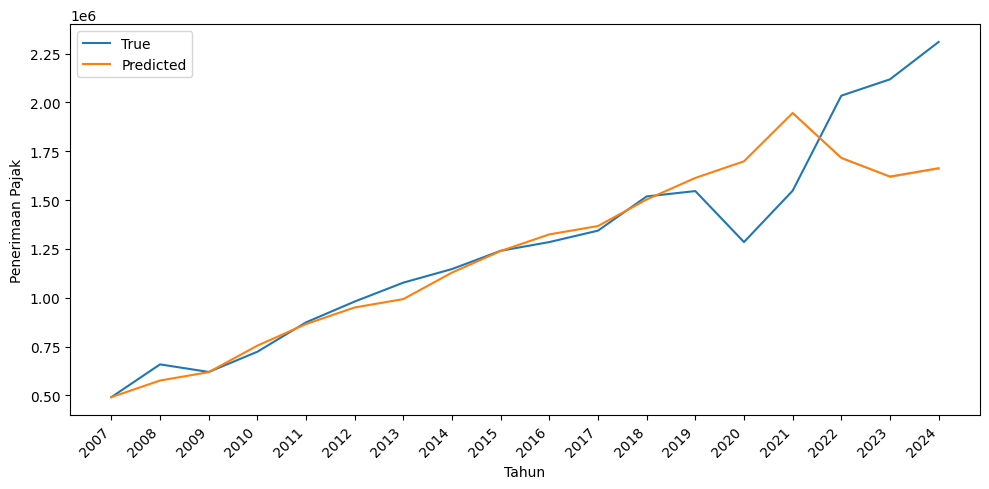

In [30]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df['Tahun'], df['Penerimaan Pajak'], label='True')
plt.plot(df['Tahun'], df['yhat_combined'], label='Predicted')
plt.fill_between(df['Tahun'][train_size:], y_pred_combined - 1.96 * sigma, y_pred_combined + 1.96 * sigma, alpha=0.2, color='k')
plt.legend()
plt.xlabel('Tahun')
plt.ylabel('Penerimaan Pajak')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

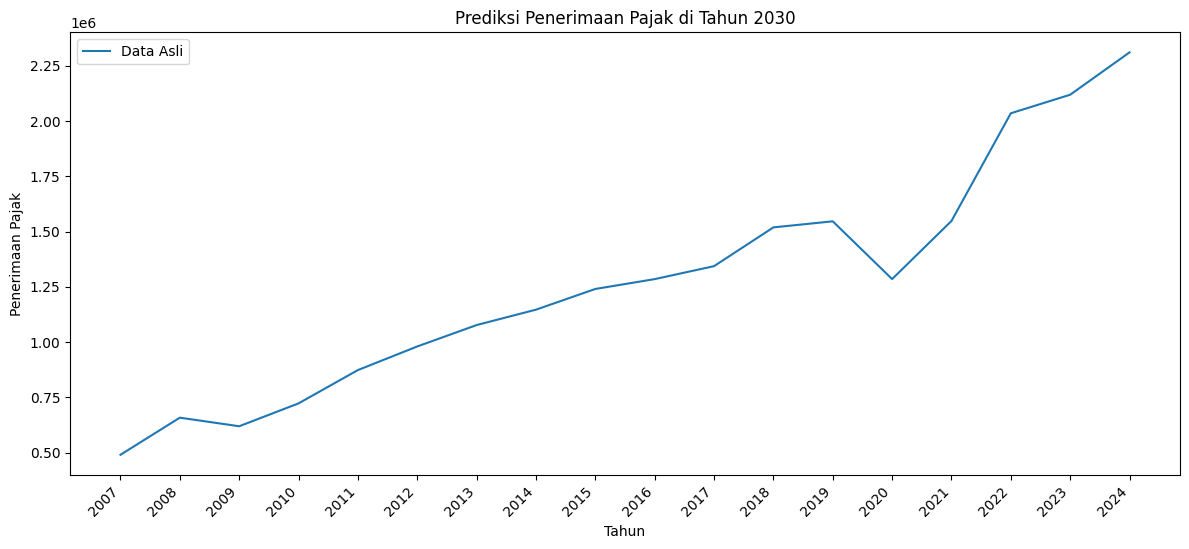

In [27]:
# Predict for the year 2030
future_residuals = np.arange(len(scaled_residuals), len(scaled_residuals) + 10 + 1).reshape(-1, 1)
future_residuals_pred, sigma_future = gp.predict(future_residuals, return_std=True)

# Ensure the year 2030 is included in the future dataframe
if '2030-12-31' not in forecast['ds'].values:
    future = model_prophet.make_future_dataframe(periods=10, freq='YE')  # Use 'A' for annual frequency
    forecast = model_prophet.predict(future)

# Extract the prediction for 2030
prediksi_2030_prophet = forecast[forecast['ds'] == '2030-12-31']['yhat'].values[0]
prediksi_2030_residual = scaler.inverse_transform(future_residuals_pred[-1].reshape(-1, 1))[0][0]
prediksi_2030 = prediksi_2030_prophet + prediksi_2030_residual

# Plot the prediction for 2030
plt.figure(figsize=(12, 6))
plt.plot(df['Tahun'], df['Penerimaan Pajak'], label="Data Asli")
# plt.scatter([2030], [prediksi_2030], color='red', label="Prediksi 2030")
plt.title("Prediksi Penerimaan Pajak di Tahun 2030")
plt.xlabel("Tahun")
plt.ylabel("Penerimaan Pajak")
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.subplots_adjust(bottom=0.2)  # Add more padding to the bottom
plt.show()

In [28]:
print(f'Prediction for 2030: {prediksi_2030}')

Prediction for 2030: 2137339.160801396
